In [17]:
import pandas as pd

df = pd.read_csv("matricula-componente-20206.csv",sep=';')#necessário pegar as matrículas de cada semestre que for adicionar na análise

profs = pd.read_csv("docentes.csv",sep=";")
#http://dados.ufrn.br/dataset/8bf1a468-48ff-4f4d-95ee-b17b7a3a5592/resource/ff0a457e-76fa-4aca-ad99-48aebd7db070/download/docentes.csv

profs = profs[profs['lotacao'].str.contains("ESCOLA DE CIÊNCIAS E TECNOLOGIA")]#DEPARTAMENTO DE ENGENHARIA DE COMPUTACAO E AUTOMACAO

componentes = pd.read_csv("componentes-curriculares-presenciais.csv",sep=";",usecols=["id_componente","codigo","nome","unidade_responsavel"],error_bad_lines=False)
#http://dados.ufrn.br/dataset/3fea67e8-6916-4ed0-aaa6-9a8ca06a9bdc/resource/9a3521d2-4bc5-4fda-93f0-f701c8a20727/download/componentes-curriculares-presenciais.csv

componentes = componentes[componentes['unidade_responsavel'].str.contains("ESCOLA DE CIÊNCIAS E TECNOLOGIA")]#DEPARTAMENTO DE ENGENHARIA DE COMPUTACAO E AUTOMACAO


turmas = pd.read_csv("turmas-20206.csv",sep=";",usecols=["id_turma","id_componente_curricular","codigo_turma","siape","local","situacao_turma"])
#necessário pear as turmas de cada semestre que for adicionar na análise

pd.options.mode.chained_assignment = None #removendo warning de copia no assigment do pandas

In [18]:
turmas = turmas.dropna(axis=0)
turmas['siape'] = turmas['siape'].astype(int)
profs['siape'] = profs['siape'].astype(int)
componentes['id_componente'] = componentes['id_componente'].astype(int)
turmas['id_componente_curricular'] = turmas['id_componente_curricular'].astype(int)


print(turmas.shape)

turmas = pd.merge(turmas,profs, how='inner', on='siape')

turmas = pd.merge(turmas,componentes, how='inner', left_on='id_componente_curricular',right_on='id_componente')

turmas = turmas.rename(columns={'nome_x':'nome_prof','nome_y':'nome_materia'})

turmas.head()

(9549, 6)


,id_turma,codigo_turma,siape,id_componente_curricular,local,situacao_turma,nome_prof,sexo,formacao,tipo_jornada_trabalho,vinculo,categoria,classe_funcional,id_unidade_lotacao,lotacao,admissao,id_componente,codigo,nome_materia,unidade_responsavel
0,57653677,02,1672787,57586,ECT remoto,CONSOLIDADA,JOSINALDO MENEZES DA SILVA,M,DOUTORADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DO MAGISTERIO SUPERIOR,Classe D - Associado ...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA
1,57653692,05,1672787,57586,ECT remoto,CONSOLIDADA,JOSINALDO MENEZES DA SILVA,M,DOUTORADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DO MAGISTERIO SUPERIOR,Classe D - Associado ...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA
2,57653689,03,3550015,57586,ECT remoto,CONSOLIDADA,FRANCISCO EDSON DA SILVA,M,DOUTORADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DO MAGISTERIO SUPERIOR,Classe D - Associado ...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA
3,57653690,04,3550015,57586,ECT remoto,CONSOLIDADA,FRANCISCO EDSON DA SILVA,M,DOUTORADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DO MAGISTERIO SUPERIOR,Classe D - Associado ...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA
4,57656795,01,3550015,57586,ECT remoto,CONSOLIDADA,FRANCISCO EDSON DA SILVA,M,DOUTORADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DO MAGISTERIO SUPERIOR,Classe D - Associado ...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA


In [19]:
df = df[['id_turma','descricao','discente']].drop_duplicates()

#Tabela pivot com a id das turmas como indice e o numero de alunos para cada valor de descricão(aprovado, reprovado etc.)
matricula_pivot = df.pivot_table(index=["id_turma"], columns="descricao", values=["discente"], aggfunc="count").fillna(0)
#Adiciona coluna com o numero total de alunos inscritos na turma
matricula_pivot['total'] = matricula_pivot.sum(axis=1)
#Separa apenas aqueles que foram aprovados
index = matricula_pivot.index
aprovados = matricula_pivot.loc[index,(slice(None),['APROVADO', 'APROVADO POR NOTA'])].sum(axis=1)
matricula_pivot['total_aprovados'] = aprovados
#descobre o valor para a taxa de aprovação de cada turma
aprovacao = aprovados / matricula_pivot['total']
matricula_pivot['aprovacao'] = aprovacao
#Manter no dataframe apenas os valores relevantes
matricula_pivot.columns = matricula_pivot.columns.droplevel(1)
#matricula_pivot = matricula_pivot.drop(columns=['discente'])

matricula_pivot = matricula_pivot[['total_aprovados','total','aprovacao']]

#criando uma coluna para os indices da tabela pivo
matricula_pivot['id_turma'] = ""

iterador = 0
for idx,row in matricula_pivot.iterrows():
    matricula_pivot.loc[idx,'id_turma'] = matricula_pivot.index.values[iterador]
    iterador = iterador + 1
    
matricula_pivot.index.name = None
matricula_pivot.head()


,total_aprovados,total,aprovacao,id_turma
57652982,38.0,62.0,0.612903,57652982
57652983,23.0,57.0,0.403509,57652983
57652984,41.0,56.0,0.732143,57652984
57652985,29.0,37.0,0.783784,57652985
57652986,43.0,61.0,0.704918,57652986


In [20]:
print(turmas.shape)
print(matricula_pivot.shape)
print(turmas.shape[0]*matricula_pivot.shape[0])

turmas = pd.merge(turmas,matricula_pivot, how='inner', on='id_turma')

#turmas
turmas.head()

(313, 20)
(5814, 4)
1819782


,id_turma,codigo_turma,siape,id_componente_curricular,local,situacao_turma,nome_prof,sexo,formacao,tipo_jornada_trabalho,...,id_unidade_lotacao,lotacao,admissao,id_componente,codigo,nome_materia,unidade_responsavel,total_aprovados,total,aprovacao
0,57653677,02,1672787,57586,ECT remoto,CONSOLIDADA,JOSINALDO MENEZES DA SILVA,M,DOUTORADO,Dedicação exclusiva,...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA,115.0,320.0,0.359375
1,57653692,05,1672787,57586,ECT remoto,CONSOLIDADA,JOSINALDO MENEZES DA SILVA,M,DOUTORADO,Dedicação exclusiva,...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA,86.0,281.0,0.306050
2,57653689,03,3550015,57586,ECT remoto,CONSOLIDADA,FRANCISCO EDSON DA SILVA,M,DOUTORADO,Dedicação exclusiva,...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA,72.0,178.0,0.404494
3,57653690,04,3550015,57586,ECT remoto,CONSOLIDADA,FRANCISCO EDSON DA SILVA,M,DOUTORADO,Dedicação exclusiva,...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2009/01/27 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA,35.0,139.0,0.251799
4,57653690,04,1912054,57586,ECT remoto,CONSOLIDADA,JOAO VITAL DA CUNHA JUNIOR,M,DOUTORADO,Dedicação exclusiva,...,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2016/02/04 00:00:00.000000000,57586,ECT2101,PRÉ-CÁLCULO,ESCOLA DE CIÊNCIAS E TECNOLOGIA,35.0,139.0,0.251799


In [21]:
csv_export = turmas[turmas['situacao_turma'] == "CONSOLIDADA"]
csv_export = csv_export[turmas['nome_prof'] != ""]
csv_export = csv_export[turmas['aprovacao'] != ""]

csv_export = csv_export.drop(['codigo_turma','siape','local','sexo','formacao','tipo_jornada_trabalho','vinculo',
                                 'categoria','classe_funcional','id_unidade_lotacao','lotacao','admissao',
                                  'unidade_responsavel','id_componente','id_componente_curricular'],axis=1)

csv_export.to_csv("20206_resultado.csv",sep=";",index=False,encoding="utf-8")
#necessário 1 export para cada semestre a ser analizado

#csv_export

C:\Users\the_p\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\the_p\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


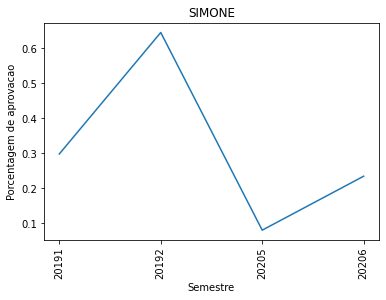

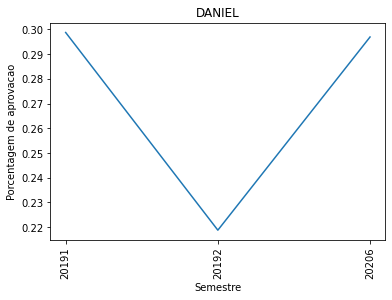

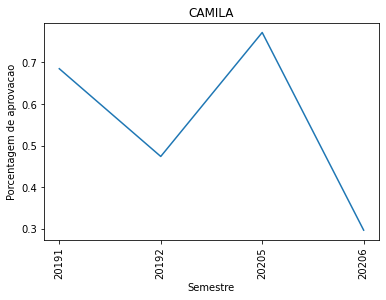

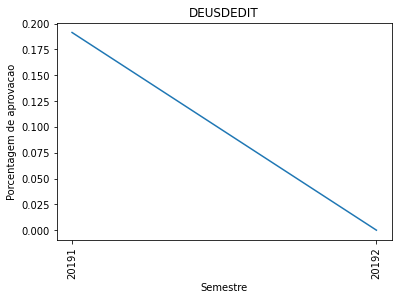

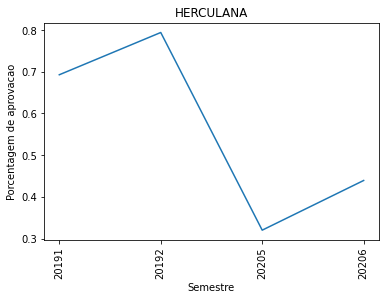

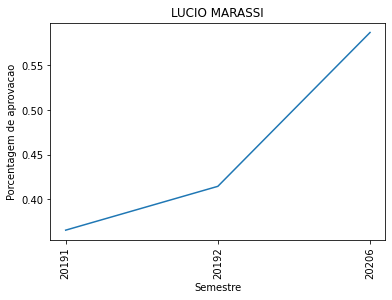

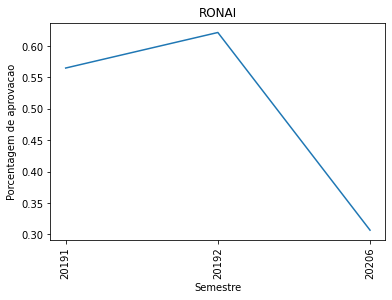

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline



res20206 = pd.read_csv("20206_resultado.csv",sep=";",encoding="utf-8")
res20205 = pd.read_csv("20205_resultado.csv",sep=";",encoding="utf-8")
res20192 = pd.read_csv("20192_resultado.csv",sep=";",encoding="utf-8")
res20191 = pd.read_csv("20191_resultado.csv",sep=";",encoding="utf-8")

#names = ['TIAGO','AFFONSO','SAMUEL','MARCELO','LUIZ FELIPE','RICARDO']
names = ['SIMONE','DANIEL','CAMILA','DEUSDEDIT','HERCULANA','LUCIO MARASSI','RONAI'] #lista de professores a serem buscados


for name in names:
    r1 = res20206.loc[res20206['nome_prof'].str.contains(name)]
    r1['semestre'] = "20206"
    r2 = res20205.loc[res20205['nome_prof'].str.contains(name)]
    r2['semestre'] = "20205"
    r3 = res20192.loc[res20192['nome_prof'].str.contains(name)]
    r3['semestre'] = "20192"
    r4 = res20191.loc[res20191['nome_prof'].str.contains(name)]
    r4['semestre'] = "20191"
    
    frames = [r1,r2,r3,r4]
    resultado = pd.concat(frames)
    resultado = resultado.groupby(['semestre'])['aprovacao'].mean().reset_index()
    
    #plotando aprovacoes e semestres por professor
    plt.title(name)
    plt.ylabel("Porcentagem de aprovacao")
    plt.xlabel("Semestre")
    plt.plot(resultado['aprovacao'])

    plt.xticks(range(len(resultado['semestre'])),resultado.semestre,rotation='vertical')
    plt.show()
